In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyrootutils

root = pyrootutils.setup_root(
    search_from="../src/",
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.utils.pylogger import setup_logger
from src.models.components.unimatch.geometry import coords_grid
setup_logger()

<Logger base (INFO)>

In [5]:
# load config
with hydra.initialize(config_path="../configs/", version_base="1.1"):
    cfg = hydra.compose(
        config_name="eval",
        overrides=[
            "experiment=doduo_train",
        ],
        return_hydra_config=True,
    )
# deterministic
torch.set_grad_enabled(False)
torch.backends.cudnn.deterministic = True
# initialize and load model
datamodule = hydra.utils.instantiate(cfg.datamodule)
loggers = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = hydra.utils.instantiate(cfg.model, datamodule=datamodule, loggers=loggers, device=device)
model.load_ckpt("../data/doduo.ckpt")
_ = model.net.eval()

rank: 0 23-07-21 09:54:06.362 - /home/zhenyu/projects/correspondence/Doduo/src/models/basic_module.py:30 - WARNING: No logger is set for this module


Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


rank: 0 23-07-21 09:54:07.100 - /home/zhenyu/projects/correspondence/Doduo/src/models/basic_module.py:106 - INFO: <All keys matched successfully>
rank: 0 23-07-21 09:54:07.100 - /home/zhenyu/projects/correspondence/Doduo/src/models/basic_module.py:111 - INFO: Optimizer not loaded, ckpt: True, self: False
rank: 0 23-07-21 09:54:07.101 - /home/zhenyu/projects/correspondence/Doduo/src/models/basic_module.py:117 - INFO: Scheduler not loaded, ckpt: True, self: False


In [6]:
import cv2
from PIL import Image
from torchvision import transforms

IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]
resize_size = (240, 320)
transform = transforms.Compose(
    [
        transforms.Resize(resize_size),
        lambda x: transforms.ToTensor()(x)[:3],
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

In [7]:
# load image
imfile1 = f"../data/imgs_src.png"
imfile2 = f"../data/imgs_dst.png"

frame_src = transform(Image.open(imfile1)).unsqueeze(0).cuda()
frame_dst = transform(Image.open(imfile2)).unsqueeze(0).cuda()
frame1_img = np.array(Image.open(imfile1).resize((resize_size[1], resize_size[0])))
frame2_img = np.array(Image.open(imfile2).resize((resize_size[1], resize_size[0])))

In [8]:
# inference dense correspondence
_, vis_dict = model.net({'frame_src': frame_src, 'frame_dst': frame_dst}, return_feature=True)
flow = vis_dict['flow']
flow_coords = coords_grid(flow.size(0), flow.size(2), flow.size(3)).to(flow.device)
matching = flow + flow_coords
matching = matching[0].long().cpu().numpy()

/home/zhenyu/projects/correspondence/Doduo/src/models/components/unimatch/position.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/zhenyu/miniconda3/envs/corr-fomo/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


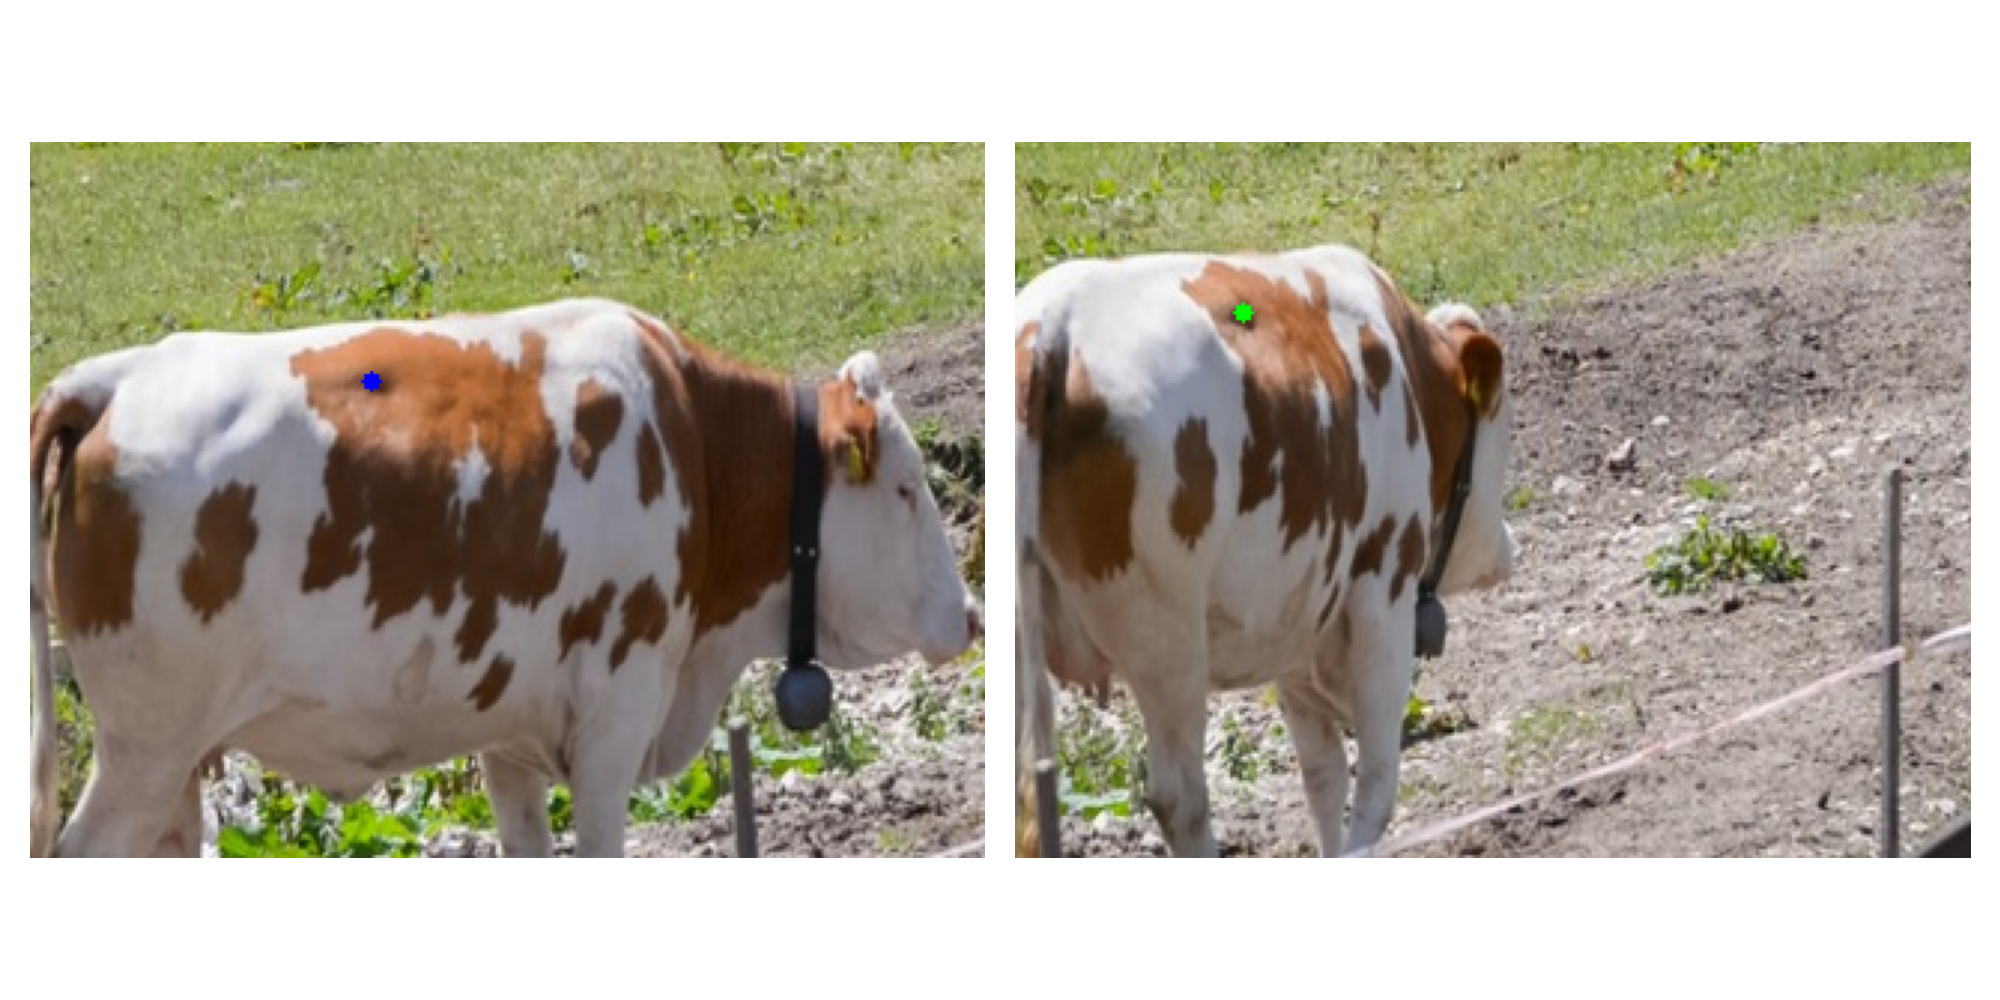

In [12]:
# interactive visualization of correspondence
# click on left image and get corresponding point on the right
%matplotlib nbagg
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(frame1_img)
axs[0].axis("off")
axs[1].imshow(frame2_img)
axs[1].axis("off")

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        frame1_img_mark = cv2.circle(frame1_img.copy(), (x, y), 3, (0, 0, 255), -1)
        max_x, max_y = matching[:, y, x]
        frame2_img_mark = cv2.circle(frame2_img.copy(), (max_x, max_y), 3, (0, 255, 0), -1)
        axs[0].imshow(frame1_img_mark)
        axs[0].axis("off")
        axs[1].imshow(frame2_img_mark)
        axs[1].axis("off")
        plt.draw()

cid = fig.canvas.mpl_connect("button_press_event", onclick)
plt.tight_layout()
plt.show()